# <span style="color:red; font-weight:bold;">Mini Project 1 NSSP</span>

Group C: Eloise Habek, Luca Jimenez, Zoé Monnard, Valentina Pucci

---


## <u>Part 1</u>

### Preliminary code

In [61]:
import sys
import os
import os.path as op


#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
import utils
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"

###################
# Load other relevant libraries for the project
##################
import fsl.wrappers, statsmodels
from fsl.wrappers import fslmaths
import dipy
import os.path as op
import nibabel as nib

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import subprocess
import os
import nibabel as nib
from nilearn.image import concat_imgs, new_img_like


In [3]:
%gui wx

In [6]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

In [7]:
# Define a helper function to create directories if they don't exist
def mkdir_no_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Dataset and subject details
dataset_id = 'ds000171'
subject = '01'

# Set up download paths
sample_path = "dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""), sample_path, dataset_id)

# Create subject-specific directories
subject_dir = 'sub-control{}'.format(subject)
func_path = op.join(bids_root, subject_dir, 'func')

# Ensure directories exist
mkdir_no_exist(op.join(bids_root, subject_dir))
mkdir_no_exist(func_path)

In [5]:
# Prepare the download command
command = [
    "openneuro-py", "download", 
    "--dataset", dataset_id,
    "--target-dir", bids_root,
    "--include", subject_dir
]

# Run the command with error handling
try:
    result = subprocess.run(command, check=True, capture_output=True, text=True)
    print("Download completed successfully.")
except subprocess.CalledProcessError as e:
    print("Command failed with exit code", e.returncode)
    print("Error message:", e.stderr)
    print("Output:", e.stdout)

# Display directories

from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
print_dir_tree(bids_root, max_depth=4)

Download completed successfully.
|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


In [6]:
import glob

# code for deleting runs 4 and 5
directory = 'dataset/ds000171/sub-control01/func'  
search_strings = ['run-4', 'run-5'] 

# initialize list where files to be deleted will be stored
files_to_delete = []

# find files containing either of the strings
for search_string in search_strings:
    files_to_delete.extend(glob.glob(os.path.join(directory, f'*{search_string}*')))

# remove duplicates (if any file matches both strings)
files_to_delete = list(set(files_to_delete))

# Loop through the files and delete them
for file in files_to_delete:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")
        
print_dir_tree(bids_root, max_depth=4)

Deleted: dataset/ds000171/sub-control01/func/sub-control01_task-nonmusic_run-5_bold.nii.gz
Deleted: dataset/ds000171/sub-control01/func/sub-control01_task-nonmusic_run-5_events.tsv
Deleted: dataset/ds000171/sub-control01/func/sub-control01_task-nonmusic_run-4_bold.nii.gz
Deleted: dataset/ds000171/sub-control01/func/sub-control01_task-nonmusic_run-4_events.tsv
|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv


In [8]:
# Create prepocessing directories (derivatives)

mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'fmap'))

### <u>Preprocessing 1:</u> standardization and concatenation

In [8]:
# Define paths (update these paths according to your dataset location)
data_path = 'dataset/ds000171/sub-control01/func/'
output_path = '/dataset/output/'

# List all files in the directory
all_files = os.listdir(data_path)

# Filter the files to include only NIfTI files ('.nii' or '.nii.gz')
nifti_files = [os.path.join(data_path, f) for f in all_files if f.endswith('.nii') or f.endswith('.nii.gz')]
nifti_files.sort()

# Initialize a list to hold standardized images
standardized_imgs = []

# Standardize each image
for file in nifti_files:
    # Load the image
    img = nib.load(file)
    img_data = img.get_fdata()

    # Standardize the image (mean = 0, std = 1)

    # standardizing by subtracting mean and dividing by std (z-score method)
    img_mean = np.mean(img_data)
    img_std = np.std(img_data)
    standardized_data = (img_data - img_mean) / img_std

    # standardizing with max-min method
    #img_min = np.min(img_data)
    #img_max = np.max(img_data)
    #standardized_data = (img_data - img_min) / (img_max - img_min) 
    # Iterate over the 105 elements in the last dimension
    for i in range(standardized_data.shape[3]):
    	# Calculate the mean of the (80, 80, 50) slice at index i
    	mean_value = np.mean(standardized_data[..., i], axis=(0, 1, 2), keepdims=True)
   	 
    	# Subtract the mean from each (80, 80, 50) slice at index i
    	standardized_data[..., i] -= mean_value

    # Create a new standardized NIfTI image
    standardized_img = new_img_like(img, standardized_data)
    print(standardized_img)
    standardized_imgs.append(standardized_img)
    
    # Print out the mean and std of the standardized data to verify
    print(f"File: {file}, Mean after standardization: {np.mean(standardized_data)}, Std after standardization: {np.std(standardized_data)}")


# Check that we have found the right files
print(f"Found {len(nifti_files)} NIfTI files to concatenate.")

# Concatenate all standardized images
concatenated_img = concat_imgs(standardized_imgs)
print(concatenated_img.shape)

# Save the concatenated image
output_path = 'dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated.nii.gz'  # Update the output path
concatenated_img.to_filename(output_path)
print(f"Concatenated and standardized image saved to {output_path}")


<class 'nibabel.nifti1.Nifti1Image'>
data shape (80, 80, 50, 105)
affine:
[[-2.89823341e+00  0.00000000e+00  1.04698524e-01  1.18931046e+02]
 [-6.50556833e-02  2.22152901e+00 -1.92718816e+00 -7.74534302e+01]
 [ 7.75302127e-02  1.86408401e+00  2.29673338e+00 -1.40277512e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  80  80  50 105   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.   2.9  2.9  3.   1.   1.   1.   1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0

In [9]:
fsleyesDisplay.load('dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated.nii.gz')

### Anatomical preprocessing

In [10]:
import os.path as op
from mne.datasets import sample
# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)

In [30]:
# PREPROCESSING anatomical 1

# SKULL STRIPPING (from lab 2)

# Skull stripping function
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping (you'll learn more about it next week!).
    # For now all you need to do is that we remove the bones and flesh from the MRI to get the brain!
    subject = 'sub-control{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-control{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-control{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "01", True)



Done with BET.


In [31]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    ###########################
    # Solution
    # By reading fslmaths documentation, one can see that the -mas option is exactly what we desire.
    ###########################
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask.nii.gz') # The mask to use

########################
# CHOOSE ONE OF THE TWO TO IMPLEMENT IT AND LAUNCH IT
########################
apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [32]:

fsleyesDisplay.load(betted_brain_path)

### apply skull stripping to fucntional

In [34]:
import tempfile

def skull_stripping_func(input_file, output_file, robust=False):
    """
    Perform skull stripping on a 4D MRI dataset using the Brain Extraction Tool (BET) .
    This function takes a 4D NIfTI file, applies skull stripping to each 3D volume (timepoint) using FSL's BET command, and saves the skull-stripped 4D data to a new NIfTI file. Skull stripping removes non-brain tissues, isolating the brain region for further analysis.
    Parameters :
    input file:
    output file :
    a string with the path to the input 4D NIfTI file containing MRI data. a string with the path to the output NIfTI file where the skull stripped data will be saved.
    robust (optional): a bool that if True, enables BET's robust mode (-R), which provides improved handling for datasets with
    unusual brain shapes or orientations. Defaults to False.
    """
    # Load the 4D fMRI data
    img = nib. load(input_file)
    data = img.get_fdata()
    
    # Create an array to hold the stripped data
    stripped_data = np.zeros_like(data)
    
    # Iterate over each timepoint (volume)
    for t in range (data. shape[-1]) :
        # Extract the volume at timepoint t
        volume = data[..., t]
        # Create temporary NIfTI files (for the current volume and for the bet output volume)
        with tempfile.NamedTemporaryFile(suffix=".nii.gz") as tmp_input_file, tempfile.NamedTemporaryFile(suffix=".nii.gz") as tmp_output_file:
            # Save the current volume to a temporary NIfTI file (input for BET)
            nib.save(nib.Nifti1Image(volume, img.affine), tmp_input_file.name)
            # Run BET skull stripping and save in temporary output file
            os.system(f'bet {tmp_input_file.name} {tmp_output_file.name} -m {"-R" if robust else ""}')
            # Load the stripped output and store it in the final array
            stripped_volume = nib.load(tmp_output_file.name).get_fdata()
            stripped_data[..., t] = stripped_volume
    # Save the final 4D stripped data to the output file
    stripped_img = nib.Nifti1Image(stripped_data, img.affine)
    nib.save(stripped_img, output_file)
    print(f"Saved BET skull stripped data to {output_file}")

In [35]:
input_file = op.join(preproc_root, 'sub-control01', 'func', 'concatenated.nii.gz')
output_file =  op.join(preproc_root, 'sub-control01', 'func', 'concatenated_stripped.nii.gz')

skull_stripping_func(input_file, output_file, robust=False)

Saved BET skull stripped data to /data/11.04/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_stripped.nii.gz


In [36]:
fsleyesDisplay.load(output_file)

### <u>Preprocessing 2:</u> motion correction

In [37]:
from fsl.wrappers import mcflirt

In [30]:
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

In [39]:
concat_data = os.path.join(preproc_root, 'sub-control01', 'func', 'concatenated_stripped')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco')
mcflirt(infile=concat_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /data/11.04/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [40]:
#fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_moco_data)

#### Evaluation of FD

In [41]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.002893,0.003160,-0.000369,-0.069511,-0.514683,-0.478104
1,-0.002872,0.003153,-0.000387,-0.087059,-0.474782,-0.497031
2,-0.002910,0.002948,-0.000100,-0.074428,-0.466098,-0.470533
3,-0.002881,0.003415,-0.000637,-0.081762,-0.470202,-0.488883
4,-0.002627,0.003437,-0.000522,-0.086950,-0.467876,-0.508811
...,...,...,...,...,...,...
310,0.009186,0.000405,-0.002055,-0.095887,0.438433,0.233487
311,0.009232,0.000055,-0.002172,-0.095850,0.416507,0.218399
312,0.009044,0.000340,-0.002179,-0.093510,0.427459,0.229128
313,0.009153,0.000221,-0.002243,-0.100109,0.431806,0.191977


In [42]:
# removing FD displacement outliers
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
      #this ums the absolute displaccements across all motion param, so that it represents the total FD for one time point
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()
threshold = 0.3

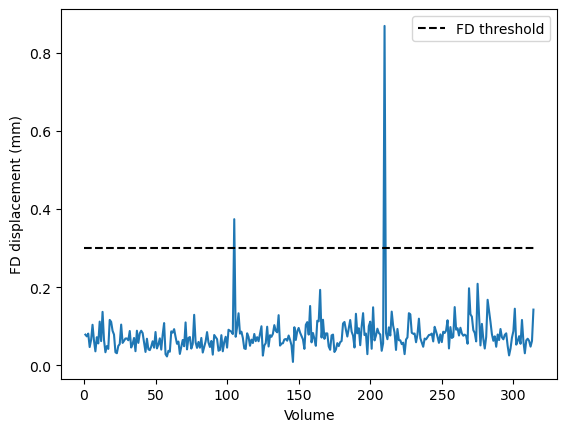

In [43]:
import matplotlib.pyplot as plt
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 315,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [44]:
print(len(fd))
fd_outliers = np.where(fd > threshold)[0] + 1
print(fd_outliers)

314
[105 210]


### <u>Preprocessing 3:</u> smoothing

In [8]:
moco_path=op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco')

In [9]:
cmd = 'fslmaths {} -s {} {}_smoothed-4mm'.format(moco_path, 4/2.3548, moco_path)
subprocess.run(['fslmaths',moco_path, '-s', str(4/2.3548), '{}_smoothed-4mm'.format(moco_path)])

CompletedProcess(args=['fslmaths', '/data/11.04/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_moco', '-s', '1.6986580601324954', '/data/11.04/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_moco_smoothed-4mm'], returncode=0)

In [10]:
fsleyesDisplay.load(moco_path + '_smoothed-4mm')

### <u>First level analysis:</u> GLM

In [9]:
################
     #GLM

#NB: the GLM is runned at the subject level
##################

func_path = op.join(bids_root, 'sub-control01', 'func')

# Load events for multiple subjects/runs
event1 = pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
event2 = pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
event3 = pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-3_events.tsv'), sep='\t')

event1['run'] = 1
event2['run'] = 2
event3['run'] = 3

# Concatenate all events into a single DataFrame
events = pd.concat([event1, event2, event3], ignore_index=True)

# Adjust onsets to avoid overlaps
for run in range(2, 6):
    events.loc[events['run'] == run, 'onset'] += (run - 1) * 312  # Adjust onsets

#print(events)
#print(event1)

In [10]:
# WHY CONCATENATE?
# You want to increase statistical power: 
    # Combining multiple runs together gives you more data points, which can improve the robustness of your results and increase the sensitivity to detect true brain activations.
# Same task across multiple runs:
    # If the subject performed the same task across different runs, concatenating the runs allows you to model all the data within one statistical framework.
# Uniform analysis: 
    # Instead of analyzing each run separately and dealing with separate outputs, concatenation provides a way to simplify the analysis. You can fit a single model to the combined data, which can make your interpretation easier.

In [11]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

fmri_img =op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco_smoothed-4mm.nii.gz')
t_r = 3  # Repetition time (TR)

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
# NOISE MODEL:
    #'ar1': First-order autoregressive model, which assumes that the noise at one time point is correlated with the previous time point. This is widely used in fMRI to account for temporal autocorrelations in the data.
    #'ols': Ordinary Least Squares, which does not model autocorrelation but assumes the noise is independent and identically distributed (less common in fMRI).
    
# HRF MODEL:
    #'glover': The default HRF based on the canonical model by Glover.
    #'spm': Based on the HRF model used by SPM software (includes derivatives to capture variability in timing and duration).
    #'fir': Finite Impulse Response, used when you want to estimate the response in a nonparametric way.
    
# DRIFT MODEL:
# This models low-frequency drifts in the fMRI signal, which are unrelated to neural activity.
# None: No drift model is used.

# HIGH PASS:
# This applies a high-pass filter to remove low-frequency noise or signal drifts. 
# high_pass = 0.01 is a Typical cutoff (in Hz), corresponding to 1/100 seconds
fmri_glm = FirstLevelModel(t_r=t_r,
                           noise_model='ols',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=None)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, events)

/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


In [48]:
# When to Use a Single Design Matrix
# Repeated Measures Analysis: 
    # If you are interested in the overall effects across multiple runs (e.g., comparing conditions across all runs), a single design matrix can be beneficial. It allows you to examine main effects, interactions, and other statistical considerations across all data.
# Consistent Task Structure: 
    # If the task structure is consistent across runs (e.g., the same conditions and timing), a single design matrix is appropriate. This helps in leveraging the increased statistical power from combining data across runs.
# Generalization: 
    # A combined design matrix provides a generalized view of how conditions are affecting brain activity across the entire experiment, accounting for variability across runs.


In [12]:
# Define contrasts for each condition
# Assuming you have the conditions defined in the design matrix
conditions = {
    'negative_music':    np.array([1, 0, 0, 0, 0]), 
    'positive_music':    np.array([0, 1, 0, 0, 0]), 
    'response':          np.array([0, 0, 1, 0, 0]),
    'tones':             np.array([0, 0, 0, 1, 0]),
    'constant':          np.array([0, 0, 0, 0, 1])
}
positive_against_negative = (conditions['positive_music'] - conditions['negative_music'])


# Print the resulting contrast vector
print("Contrast for positive against negative:", positive_against_negative)


Contrast for positive against negative: [-1  1  0  0  0]


<Axes: label='conditions'>

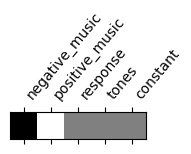

In [13]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(positive_against_negative, design_matrix=fmri_glm.design_matrices_[0])

[-1  1  0  0  0  0  0  0  0  0  0]
(315, 10)


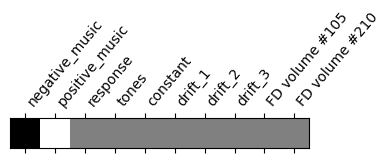

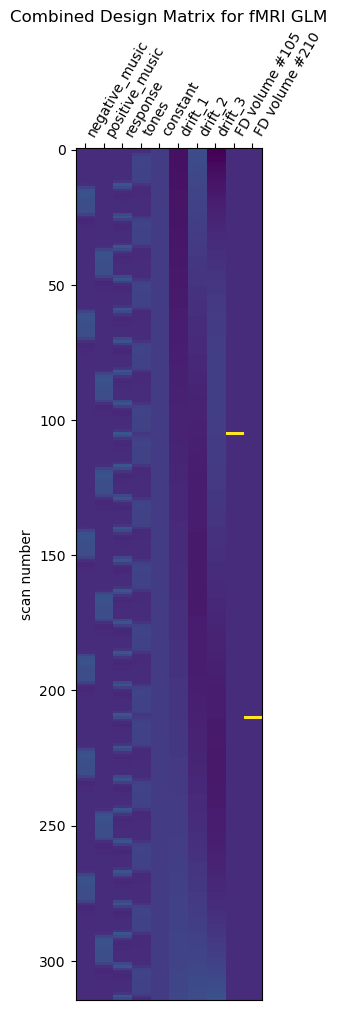

In [14]:
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level.design_matrix import _make_drift
import matplotlib.pyplot as plt

# example with signal drift, differnet num of volumes after FD displacement removal
n_scans = 315
# fd_outliers = np.array([105, 210])
frame_times = np.asarray(list(range(0, (n_scans-1)*t_r+1,t_r)))
column_values, column_names = _make_drift(drift_model='polynomial', frame_times=frame_times, order=3, high_pass=None)
design_mat = fmri_glm.design_matrices_[0]
for (col, name) in zip(column_values.T, column_names):
    positive_against_negative = np.append(positive_against_negative,0)
    design_mat[name] = col
for fd in fd_outliers:
    positive_against_negative = np.append(positive_against_negative,0)
    reg = np.zeros((n_scans,))*0.0
    reg[fd] = 1
    design_mat['FD volume #' + str(fd)] = reg
print(positive_against_negative)
print(design_mat.shape)
positive_against_negative = positive_against_negative[:10]
plot_contrast_matrix(positive_against_negative, design_matrix=design_mat)
#Including regressors - Motion outliers + drift
plot_design_matrix(design_mat)
plt.title("Combined Design Matrix for fMRI GLM")
plt.show()

In [15]:
fmri_glm = FirstLevelModel(t_r=t_r,
                           noise_model='ols',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=None)
print(design_mat.shape)
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=[design_mat])

(315, 10)


In [17]:
import nibabel as nib
z_map = fmri_glm.compute_contrast(positive_against_negative,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')
fsleyesDisplay.load('z_map_uncorrected.nii.gz')

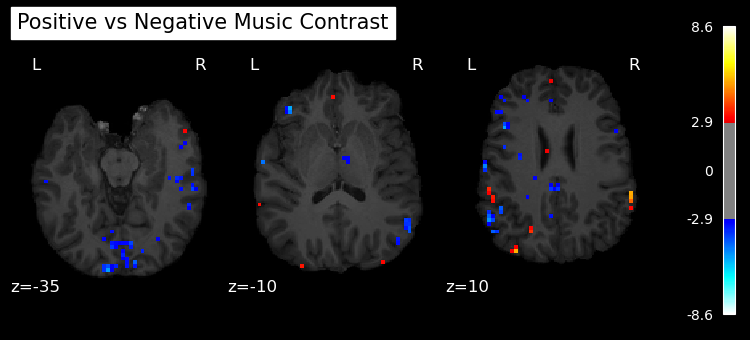

In [47]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map

anatomical = nib.load('dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w.nii.gz')

# Plot the contrast map
plot_stat_map(z_map,
              title='Positive vs Negative Music Contrast', 
              threshold=2.0,  
              bg_img = anatomical,
              cut_coords=[-35, -10, 10], 
              display_mode='z')
plt.show()

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


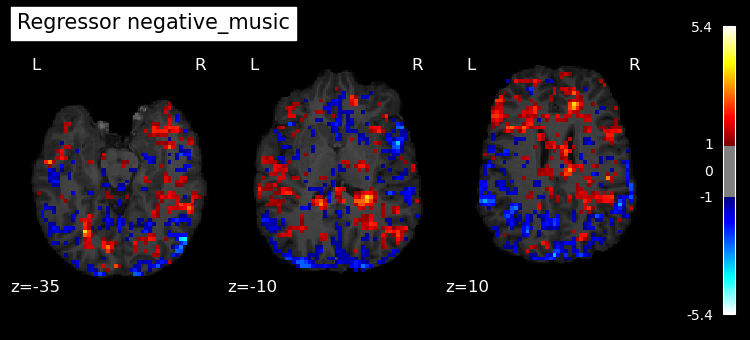

In [44]:
contrast = np.zeros(10)
dict_name = {0:'negative_music',1:'positive_music',2:'response',3:'tones'}
contrast[0]=1
print(contrast)
z_map_reg = fmri_glm.compute_contrast(contrast,output_type='z_score')
plot_stat_map(z_map_reg, 
              title=f'Regressor {dict_name[0]}', 
              threshold=1.0, 
              bg_img = anatomical,
              cut_coords=[-35, -10, 10], 
              display_mode='z')
plt.show()

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


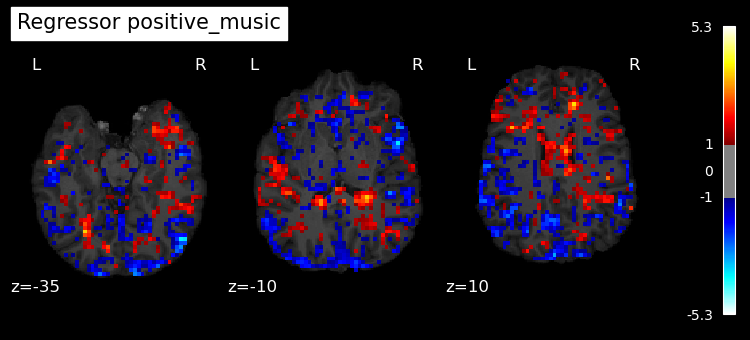

In [43]:
contrast = np.zeros(10)
dict_name = {0:'negative_music',1:'positive_music',2:'response',3:'tones'}
contrast[1]=1
print(contrast)
z_map_reg = fmri_glm.compute_contrast(contrast,output_type='z_score')
plot_stat_map(z_map_reg, 
              title=f'Regressor {dict_name[1]}', 
              threshold=1.0, 
                bg_img = anatomical,
              cut_coords=[-35, -10, 10], 
              display_mode='z')
plt.show()

In [22]:
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import load_img
import numpy as np

# Load AAL atlas
aal_atlas = datasets.fetch_atlas_aal()

# Create a masker for extracting the AAL labels
masker = NiftiLabelsMasker(labels_img=aal_atlas.maps, standardize=True)

# Ensure z_map is a valid 3D or 4D NIfTI image
# If z_map is a filename, use load_img
z_map_nifti = load_img(z_map)

# Transform the z_map to extract voxel-level time series data for the contrast map
time_series = masker.fit_transform(z_map_nifti)

# Reshape to get voxel-wise activation across regions
# Flatten each region's voxel values into a single array
voxel_activations = time_series.reshape(-1)

# Find the index of the most activated voxel
top_voxel_index = np.argmax(voxel_activations)  # Get index of maximum activation

# Retrieve the activation value and corresponding region label for the top voxel
top_activation_value = voxel_activations[top_voxel_index]
top_region_label = aal_atlas.labels[top_voxel_index // time_series.shape[1]]

# Print the most activated voxel with maximum activation
print("Top voxel with maximum activation:")
print(f"Activation: {top_activation_value:.4f} in region: {top_region_label}")

Top voxel with maximum activation:
Activation: 1.7370 in region: Precentral_L


/opt/conda/lib/python3.11/site-packages/nilearn/signal.py:74: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn(


2.919132991268752


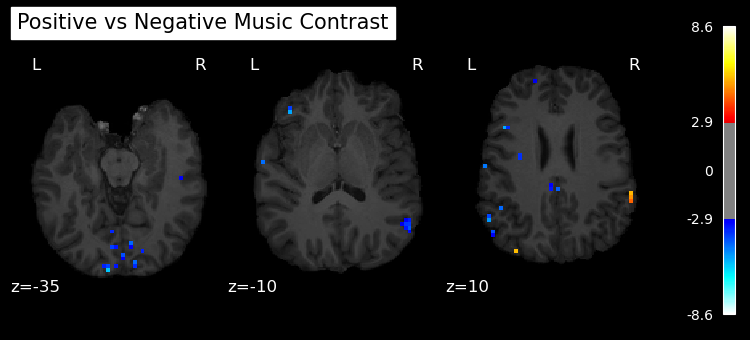

In [25]:
## FDR with clusters 
#False discovery rate - minimize se effect of making Type I error because of repeated testing

#Control the expected number of false discoveries
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
import matplotlib.pyplot as plt
from nilearn.glm import threshold_stats_img

cluster_size = 3 #minimum size of voxel cluster for the activity to be considered significant and not noise
# between 10 and 100 usually need to do testing
fdr_rate = 0.1

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

print(threshold)

anatomical = nib.load('dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w.nii.gz')

plot_stat_map(clean_map, 
              title='Positive vs Negative Music Contrast', 
              threshold=threshold, 
              bg_img = anatomical,
              cut_coords=[-35, -10, 10], 
              display_mode='z')
plt.show()
clean_map_path = 'clean_map_uncorrected.nii.gz'
nib.save(clean_map, clean_map_path)
fsleyesDisplay.load(clean_map_path)


In [35]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load('dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w.nii.gz')

In [28]:
fsleyesDisplay.load(clean_map_path)

In [26]:
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import load_img
import numpy as np

# Load AAL atlas
aal_atlas = datasets.fetch_atlas_aal()

# Create a masker for extracting the AAL labels
masker = NiftiLabelsMasker(labels_img=aal_atlas.maps, standardize=True)

# Ensure z_map is a valid 3D or 4D NIfTI image
# If z_map is a filename, use load_img
z_map_nifti = load_img(clean_map)

# Transform the z_map to extract voxel-level time series data for the contrast map
time_series = masker.fit_transform(z_map_nifti)

# Reshape to get voxel-wise activation across regions
# Flatten each region's voxel values into a single array
voxel_activations = time_series.reshape(-1)

# Find the index of the most activated voxel
top_voxel_index = np.argmax(voxel_activations)  # Get index of maximum activation

# Retrieve the activation value and corresponding region label for the top voxel
top_activation_value = voxel_activations[top_voxel_index]
top_region_label = aal_atlas.labels[top_voxel_index // time_series.shape[1]]

# Print the most activated voxel with maximum activation
print("Top voxel with maximum activation:")
print(f"Activation: {top_activation_value:.4f} in region: {top_region_label}")

Top voxel with maximum activation:
Activation: 0.4533 in region: Precentral_L


/opt/conda/lib/python3.11/site-packages/nilearn/signal.py:74: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn(


### <u>Part 2:</u> K-means clustering

In [29]:
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
img = nib.load(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco_smoothed-4mm.nii.gz'))
affine = img.affine
data = np.asanyarray(img.dataobj)
data.shape

(80, 80, 50, 315)

In [56]:
# Get the 3D shape of the individual volumes
vol_shape = data[:,:,:,0].shape # (80, 80, 50)

# Get the number of volumes
n_vols = data.shape[3] # 315

print(data.shape)
print(vol_shape)
print(n_vols)

slice_non_background = data[..., 0] != 0
samples = data[slice_non_background,:]

samples.shape # (320000, 315)

# Calculate the mean across columns (timepoints), giving the mean spatial pattern for each voxel
# spatial_means1 = samples.mean(axis=1)
spatial_means = np.mean(samples, axis = 1)
print(spatial_means.shape)

# Row means copied n_vols times so that we substract for each timepoint the spatial mean
row_means = np.repeat(spatial_means[:, np.newaxis], n_vols, axis = 1) 

# Subtract the spatial means for each row (voxel) across all timepoints
X = samples - row_means

# Verify that the spatial mean behaves as expected after subtraction
# Check if the mean of each row in X is approximately zero
mean_check = np.mean(X, axis = 1)
#print("Mean across timepoints after subtraction (should be close to zero):", mean_check)

(80, 80, 50, 315)
(80, 80, 50)
315
(106156,)


In [57]:
from copy import deepcopy
# Thus the background are also not taken in feature vectors
X_kmeans = deepcopy(X)

In [58]:
from sklearn.cluster import KMeans

max_nb_clusters = 20
avg_dist_samples = []
for nb_cluster in range(1, max_nb_clusters):
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init="auto").fit(X_kmeans.T)
    avg_dist_samples.append(kmeans.inertia_)

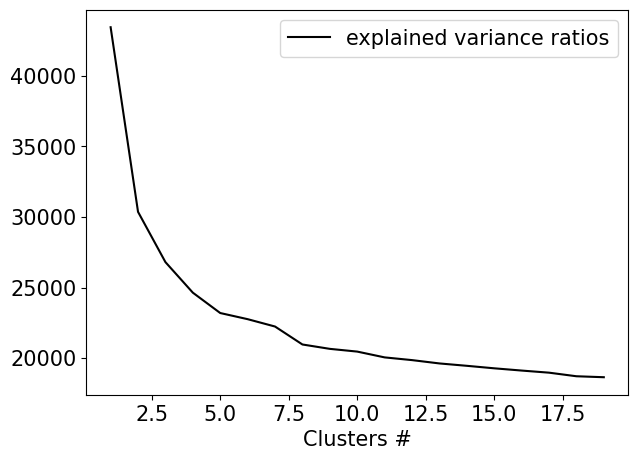

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(7,5))

ax.plot(np.arange(1, len(avg_dist_samples)+1), avg_dist_samples, label='explained variance ratios', c='k')

ax.set_xlabel('Clusters #', size=15)
ax.legend(prop={'size':15})
ax.tick_params(axis='both', which='major', labelsize=15)

# Generally, as the number of clusters increases, inertia decreases. 
# This is because adding more clusters typically allows for a better fit of the data to the clusters, 
# leading to lower distances between the samples and their respective cluster centroids.


# The plot is particularly useful for applying the "elbow method" to determine the optimal number of clusters.
# Look for a point where the rate of decrease in inertia sharply changes—this is often referred to as the "elbow" of the curve.
# It indicates a point where adding more clusters results in a diminishing return on reducing inertia.
# For example, if the inertia values drop significantly as you move from 1 to 3 clusters but then level off or decrease 
# more slowly after that, it suggests that 3 clusters might be an optimal choice.

# in our case we don't have a clear elbow, but we can see that the inertia is decreasing with the number of clusters
# and we can choose the number of clusters based on the specific needs of our analysis.

#so the elbow method is not very clear in our case

Leaderboard of Top Cluster Choices:
Rank 1: 2 clusters
Rank 2: 3 clusters
Rank 3: 5 clusters
Rank 4: 8 clusters
Rank 5: 4 clusters


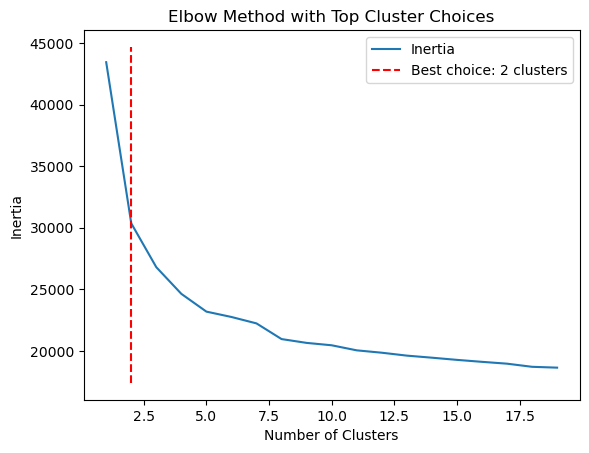

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for avg_dist_samples
# avg_dist_samples = [...]  # Ensure this is defined with your actual data

# Calculate first and second derivatives
first_derivative = np.diff(avg_dist_samples)
second_derivative = np.diff(first_derivative)

# Sort cluster numbers by their corresponding second derivative value in descending order
# to get the highest "elbow points"
elbow_indices = np.argsort(second_derivative)[::-1] + 1  # +1 to align with cluster numbers

# Show the top 5 choices for the optimal number of clusters
top_choices = elbow_indices[:5] + 1  # Adjust for Python's zero indexing to get cluster numbers

# Display the leaderboard
print("Leaderboard of Top Cluster Choices:")
for i, clusters in enumerate(top_choices, start=1):
    print(f"Rank {i}: {clusters} clusters")

# Plot the elbow graph with the top choice highlighted
optimal_clusters = top_choices[0]
x = np.arange(1, len(avg_dist_samples) + 1)
plt.plot(x, avg_dist_samples, label='Inertia')
plt.vlines(optimal_clusters, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f'Best choice: {optimal_clusters} clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method with Top Cluster Choices')
plt.legend()
plt.show()




Leaderboard of Top Cluster Choices Based on Silhouette Scores:
Rank 1: 2 clusters, Silhouette Score = 0.2643
Rank 2: 3 clusters, Silhouette Score = 0.2319
Rank 3: 4 clusters, Silhouette Score = 0.2235
Rank 4: 5 clusters, Silhouette Score = 0.1587
Rank 5: 6 clusters, Silhouette Score = 0.1272


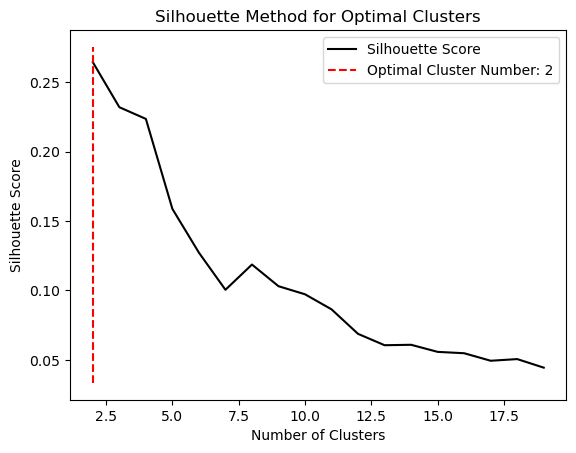

In [60]:
# we decided to implement also the silhouette method to have a more robust evaluation of the optimal number of clusters
# The silhouette method is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
# The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
max_nb_clusters = 20
silhouette_scores = []

# Calculate silhouette scores for each number of clusters
for nb_cluster in range(2, max_nb_clusters):  # Start from 2 clusters for silhouette score
	kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init="auto").fit(X_kmeans.T)
	score = silhouette_score(X_kmeans.T, kmeans.labels_)
	silhouette_scores.append(score)

# Sort indices by silhouette scores in descending order to identify top choices
sorted_indices = np.argsort(silhouette_scores)[::-1]
top_choices = sorted_indices[:5] + 2  # Adjust indices to match cluster numbers (starting from 2)

# Display the leaderboard of top silhouette scores
print("Leaderboard of Top Cluster Choices Based on Silhouette Scores:")
for i, clusters in enumerate(top_choices, start=1):
	print(f"Rank {i}: {clusters} clusters, Silhouette Score = {silhouette_scores[sorted_indices[i-1]]:.4f}")

# Plot the silhouette scores for each number of clusters
x = np.arange(2, max_nb_clusters)
optimal_clusters = top_choices[0]  # Select the top-ranked cluster as optimal
plt.plot(x, silhouette_scores, label='Silhouette Score', c='k')
plt.vlines(optimal_clusters, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f'Optimal Cluster Number: {optimal_clusters}')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal Clusters')
plt.legend()
plt.show()

#also with this method we don't have a clear perfect number of clusters, but we can see that the silhouette score is decreasing with the number of clusters


In [ ]:
# by the results we can see that the optimal number of clusters is 2

# however, we considered that only 2 clusters are not enough to represent the data
# we considered the results of each method, and by the plots we decided to use 8 clusters because:
# - it was the 5th choice in the elbow method
# - it had a peak in the silhouette method
# - it can represent the data better than 2 clusters, because we have at least 4 different clusters (one for each task) and the rest for the noise and artifacts

In [62]:
from copy import deepcopy
from sklearn.cluster import KMeans
X_kmeans = deepcopy(X)
nb_clusters = 8 # The chosen number of clusters
kmeans = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(X_kmeans.T)

kmeans_clusters = []
for cluster_idx in range(nb_clusters):
    kmeans_component = np.zeros(vol_shape)
    kmeans_component[slice_non_background] = kmeans.cluster_centers_[cluster_idx]
    kmeans_clusters.append(kmeans_component)

print(kmeans.labels_)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 4 7 7 7 7 4 7 7 4 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3
 3 3 3 3 2 3 2 3 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5
 5 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


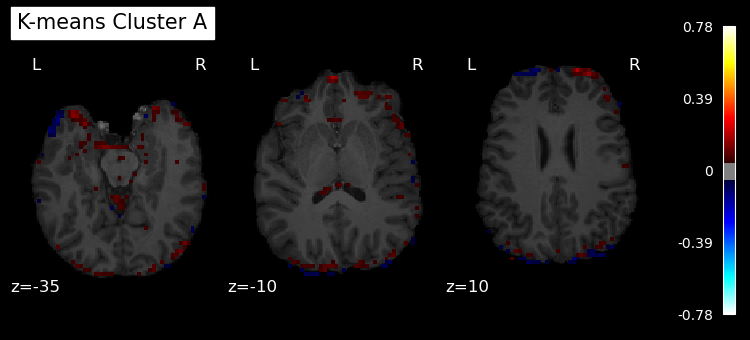

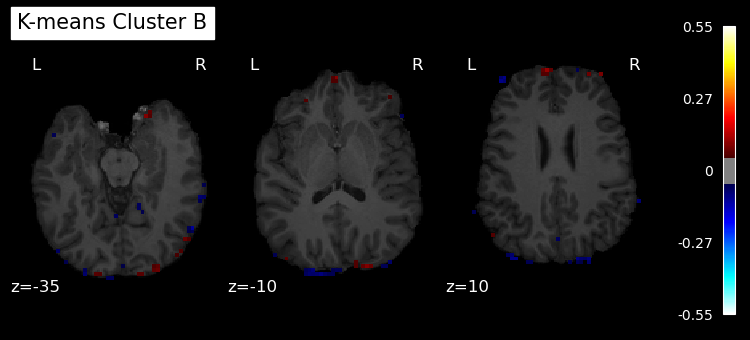

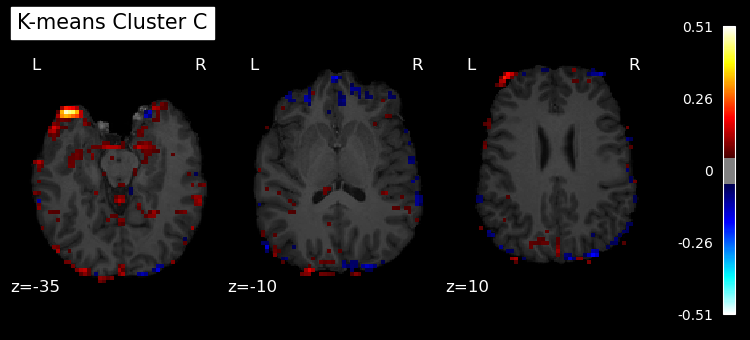

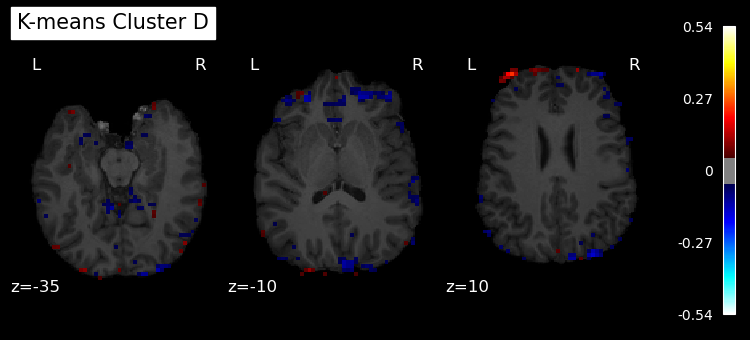

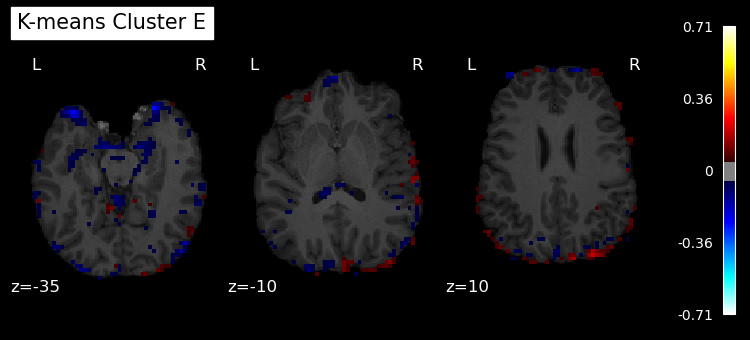

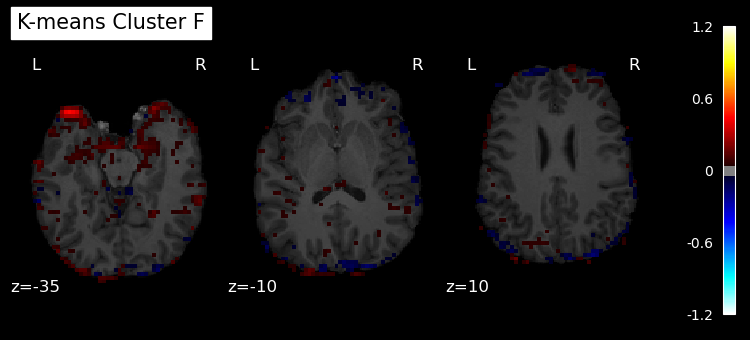

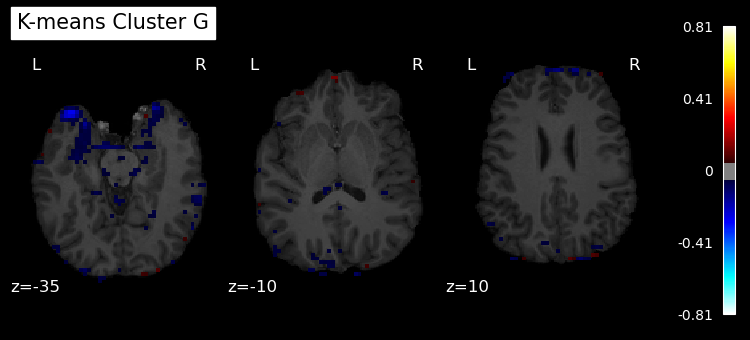

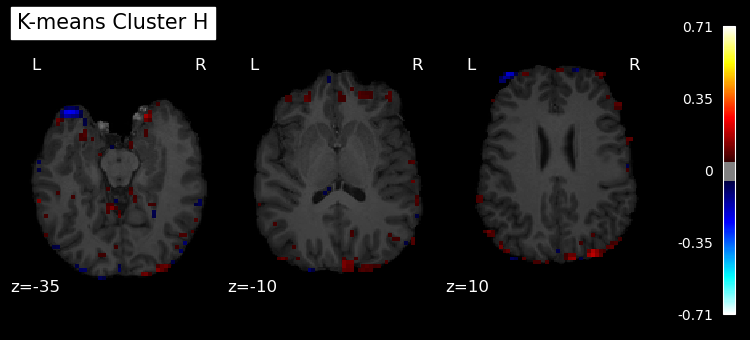

In [63]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
import matplotlib.pyplot as plt

num_clusters = np.unique(kmeans.labels_)

# Loop through clusters and plot each centroid with a unique letter identifier
for i in num_clusters:
    plot_stat_map(nib.Nifti1Image(kmeans_clusters[i], affine), 
                  bg_img=anatomical, 
                  threshold=0.05,
                  cut_coords=[-35, -10, 10],  
                  display_mode='z', 
                  black_bg=True, 
                  title=f'K-means Cluster {chr(65 + i)}')  # Assign a letter label to each centroid

In [64]:
import nibabel as nib
import numpy as np

# Assume kmeans_clusters is a list of 3D numpy arrays, each representing a cluster
# and `affine` is the affine matrix from the original NIfTI files.

# Stack clusters along a new 4th dimension to create a 4D array
clusters_4d = np.stack(kmeans_clusters, axis=-1)  # Shape will be (x, y, z, nb_clusters)

# Create a 4D NIfTI image from the stacked array
clusters_4d_img = nib.Nifti1Image(clusters_4d, affine)

# Save the 4D image as a single NIfTI file
nib.save(clusters_4d_img, 'clusters_4d.nii')
print('Saved all clusters as a 4D image in clusters_4d.nii')

Saved all clusters as a 4D image in clusters_4d.nii


In [65]:
fsleyesDisplay.load('clusters_4d.nii')

In [66]:
from nilearn.plotting import view_img
from nilearn.image import mean_img
import nibabel as nib

# Calculate the mean image to use as the background
mean_img_ = mean_img(img)

idx = 0

# Create a Nifti1Image for the cluster volume with the original affine
cluster_img = nib.Nifti1Image(kmeans_clusters[idx], affine)
# Plot the 3D interactive view
display = view_img(
    cluster_img,
    bg_img=anatomical,
    threshold=0.03,      # Adjust threshold as needed to see more/less of the cluster
    title=f'3D View of K-means Cluster {idx}',
    black_bg=True
)

# Display the interactive viewer
display.open_in_browser()
